In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import resample
from econml.dml import LinearDML
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from econml.dml import DML
from sklearn.linear_model import Lasso
## ML Treatment
file_path = 'F:/PhD/2nd Year Paper/Data/filtered_data.csv'  # Update this to the correct path if needed
data = pd.read_csv(file_path)
placebo_data = filtered_data[filtered_data['year'] < 2019].copy()
filtered_data = data.dropna(subset=['hexpf_adjusted'])
filtered_data.loc[:, 'mltreat'] = (filtered_data['year']>2016).astype(int)
filtered_data.loc[:, 'year'] = pd.to_numeric(filtered_data['year'], errors='coerce')  # Convert year to numeric
filtered_data['mltreat'] = filtered_data['mltreat'].astype(int)
print("Number of observations:", filtered_data.shape[0])

Number of observations: 866


C:\Users\yizho\AppData\Local\Temp\ipykernel_836\3504412354.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.loc[:, 'mltreat'] = (filtered_data['year']>2016).astype(int)
C:\Users\yizho\AppData\Local\Temp\ipykernel_836\3504412354.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['mltreat'] = filtered_data['mltreat'].astype(int)


In [60]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from econml.dml import CausalForestDML

# Load and prepare data
file_path = 'F:/PhD/2nd Year Paper/Data/filtered_data.csv'
data = pd.read_csv(file_path)
data = data.dropna(subset=['hexpf_adjusted'])
data['year'] = pd.to_numeric(data['year'], errors='coerce')
data['special'] = data['name'].str.lower().isin(['beijing', 'tianjin', 'shanghai', 'chongqing', 'fujian', 'hebei']).astype(int)
data = data[data['special'] == 0].copy()
data = data.sort_values(by=['name', 'year']).reset_index(drop=True)

# Generate lag variables
lag_vars = ['hexpf_adjusted', 'hos_num', 'gdp_adjusted', 'population', 'annual_patient']
for var in lag_vars:
    data[f'{var}_lag1'] = data.groupby('name')[var].shift(1)

# Drop rows with missing lags
data = data.dropna(subset=[f'{v}_lag1' for v in lag_vars])

# List of placebo treatment years
placebo_years = list(range(2013, 2018))

data_placebo = data[data['year'] < 2019].copy()

# Run placebo tests
for placebo_year in placebo_years:
    print(f"\n=== Placebo Year: {placebo_year} ===")

    df = data_placebo.copy()
    df['mltreat'] = (df['year'] > placebo_year).astype(int)

    Y = df['hexpf_adjusted']
    T = df['mltreat']

    # Build covariates
    lagged_columns = [f'{v}_lag1' for v in ['hexpf_adjusted', 'hos_num', 'gdp_adjusted', 'population', 'annual_patient']]
    X_cont = df[['hos_num', 'gdp_adjusted', 'population', 'annual_patient'] + lagged_columns]
    X_cat = pd.get_dummies(df[['name', 'year']].astype(str), drop_first=True)

    X_y = pd.concat([X_cont, X_cat], axis=1)
    X_t = pd.concat([X_cont, X_cat.drop(columns=[col for col in X_cat.columns if col.startswith('year_')])], axis=1)

    # Fit Causal Forest DML
    model_y = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
    model_t = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=500, random_state=42)

    cf_dml = CausalForestDML(
        model_y=model_y,
        model_t=model_t,
        discrete_treatment=True,
        n_estimators=100,
        min_samples_leaf=5,
        max_depth=10,
        random_state=42,
        cv=2
    )

    cf_dml.fit(Y, T, X=X_y, W=X_t)

    # Estimate ATE and CI
    ate = cf_dml.ate(X=X_y)
    lb, ub = cf_dml.ate_interval(X=X_y)
    stderr = (ub - lb) / (2 * 1.96)

    # Print results
    print(f"ATE: {ate:.4f}")
    print(f"95% CI: [{lb:.4f}, {ub:.4f}]")
    print(f"Standard Error: {stderr:.4f}")



=== Placebo Year: 2013 ===


D:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

ATE: 41.6117
95% CI: [-24.6743, 107.8978]
Standard Error: 33.8194

=== Placebo Year: 2014 ===


D:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ATE: 47.5881
95% CI: [-43.8140, 138.9902]
Standard Error: 46.6337

=== Placebo Year: 2015 ===


D:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

ATE: 13.0204
95% CI: [-101.8452, 127.8860]
Standard Error: 58.6049

=== Placebo Year: 2016 ===


D:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ATE: 10.4902
95% CI: [-93.2500, 114.2304]
Standard Error: 52.9287

=== Placebo Year: 2017 ===


D:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ATE: 91.4010
95% CI: [-57.3985, 240.2004]
Standard Error: 75.9181


# Counterfactual

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import resample
from econml.dml import LinearDML
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from econml.dml import DML
from sklearn.linear_model import Lasso
## ML Treatment
file_path = 'F:/PhD/2nd Year Paper/Data/filtered_data.csv'  # Update this to the correct path if needed
data = pd.read_csv(file_path)
filtered_data = data.dropna(subset=['hexpf_adjusted'])
filtered_data.loc[:, 'mltreat'] = (filtered_data['year']>2017).astype(int)
filtered_data.loc[:, 'year'] = pd.to_numeric(filtered_data['year'], errors='coerce')  # Convert year to numeric
filtered_data['mltreat'] = filtered_data['mltreat'].astype(int)
print("Number of observations:", filtered_data.shape[0])

Number of observations: 866


C:\Users\yizho\AppData\Local\Temp\ipykernel_836\102907358.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.loc[:, 'mltreat'] = (filtered_data['year']>2017).astype(int)
C:\Users\yizho\AppData\Local\Temp\ipykernel_836\102907358.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['mltreat'] = filtered_data['mltreat'].astype(int)


In [18]:
# Load your actual dataset here
# filtered_data = pd.read_csv("your_data.csv")

# Mark special provinces
special_provinces = ['beijing', 'tianjin', 'shanghai', 'chongqing', 'fujian', 'hebei']
filtered_data['special'] = filtered_data['name'].str.lower().isin(special_provinces).astype(int)

# Drop the special provinces
filtered_data = filtered_data[filtered_data['special'] == 0].copy()

# Proceed with sorting
filtered_data = filtered_data.sort_values(by=['name', 'year']).reset_index(drop=True)
print("Number of observations:", filtered_data.shape[0])

Number of observations: 700


C:\Users\yizho\AppData\Local\Temp\ipykernel_836\3245201112.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['special'] = filtered_data['name'].str.lower().isin(special_provinces).astype(int)


In [19]:
lag_vars = ['hexpf_adjusted', 'hos_num', 'annual_patient', 'gdp_adjusted', 'population']
for var in lag_vars:
    filtered_data[f'{var}_lag1'] = filtered_data.groupby('name')[var].shift(1)

# Drop rows with missing lags
filtered_data = filtered_data.dropna(subset=[f'{v}_lag1' for v in lag_vars])

print("Number of observations:", filtered_data.shape[0])

Number of observations: 475


In [20]:
# STEP 2: Split data
train_data = filtered_data[filtered_data['year'] < 2018].copy()
test_2020 = filtered_data[filtered_data['year'] >= 2018].copy()


# STEP 3: Create features
X_train = pd.concat([
    train_data[[f'{v}_lag1' for v in lag_vars]].copy(),
    train_data[['hos_num', 'annual_patient', 'gdp_adjusted', 'population', 'year']],
    pd.get_dummies(train_data['name'], drop_first=True)
], axis=1)
y_train = train_data['hexpf_adjusted']

X_2020 = pd.concat([
    test_2020[[f'{v}_lag1' for v in lag_vars]].copy(),
    test_2020[['hos_num', 'annual_patient', 'gdp_adjusted', 'population', 'year']],
    pd.get_dummies(test_2020['name'], drop_first=True)
], axis=1)
X_2020 = X_2020.reindex(columns=X_train.columns, fill_value=0)

# STEP 4: Bootstrap prediction intervals
n_boot = 100
all_preds = []

for _ in range(n_boot):
    boot_train = train_data.sample(frac=1.0, replace=True)
    Xb = pd.concat([
        boot_train[[f'{v}_lag1' for v in lag_vars]].copy(),
        boot_train[['hos_num', 'annual_patient', 'gdp_adjusted', 'population', 'year']],
    pd.get_dummies(boot_train['name'], drop_first=True)
    ], axis=1)
    yb = boot_train['hexpf_adjusted']
    Xb = Xb.reindex(columns=X_train.columns, fill_value=0)

    model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=None)
    model.fit(Xb, yb)
    pred_2020 = model.predict(X_2020)
    all_preds.append(pred_2020)

# STEP 5: Compute prediction means and intervals
all_preds = np.array(all_preds)
test_2020['pred_mean'] = all_preds.mean(axis=0)
test_2020['pred_lower'] = np.percentile(all_preds, 2.5, axis=0)
test_2020['pred_upper'] = np.percentile(all_preds, 97.5, axis=0)


# STEP 6: Treatment effect and CI
test_2020['treatment_effect'] = test_2020['hexpf_adjusted'] - test_2020['pred_mean']
test_2020['effect_ci_lower'] = test_2020['hexpf_adjusted'] - test_2020['pred_upper']
test_2020['effect_ci_upper'] = test_2020['hexpf_adjusted'] - test_2020['pred_lower']
test_2020['treatment_stderr'] = (test_2020['effect_ci_upper'] - test_2020['effect_ci_lower']) / (2 * 1.96)

National ATE (Year ≥ 2020): 86.16
Standard Error of National ATE: 5.67
95% CI: [75.05, 97.27]


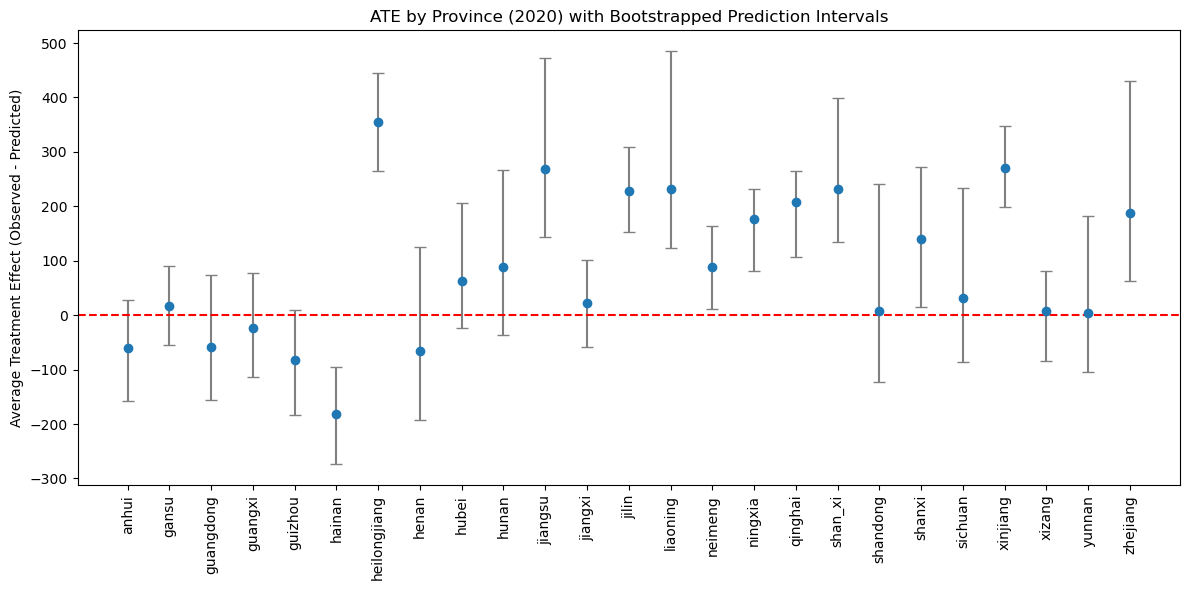

In [21]:
# National ATE and SE
national_ate = test_2020['treatment_effect'].mean()
national_se = (test_2020['treatment_stderr']**2).mean()**0.5 / (len(pltdat)**0.5)
ci_lower = national_ate - 1.96 * national_se
ci_upper = national_ate + 1.96 * national_se

print(f"National ATE (Year ≥ 2020): {national_ate:.2f}")
print(f"Standard Error of National ATE: {national_se:.2f}")

print(f"95% CI: [{ci_lower:.2f}, {ci_upper:.2f}]")

# STEP 7: Group by province and summarize
plot_df = (
    test_2020.groupby('name')[['treatment_effect', 'effect_ci_lower', 'effect_ci_upper']]
    .mean()
    .reset_index()
    .sort_values(by='name')
)

# STEP 8: Plot
plt.figure(figsize=(12, 6))
plt.errorbar(
    plot_df['name'],
    plot_df['treatment_effect'],
    yerr=[plot_df['treatment_effect'] - plot_df['effect_ci_lower'],
          plot_df['effect_ci_upper'] - plot_df['treatment_effect']],
    fmt='o', capsize=4, ecolor='gray'
)
plt.axhline(0, color='red', linestyle='--')
plt.xticks(rotation=90)
plt.title("ATE by Province (2020) with Bootstrapped Prediction Intervals")
plt.ylabel("Average Treatment Effect (Observed - Predicted)")
plt.tight_layout()
plt.show()